In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import json
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from preprocess_utensils import get_gray_image
from dataloader import normalize_image, DAVIS_test

In [2]:
with open("./uniform_samples_80.json", "r") as f:
    tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())

In [3]:
bear_data = tmp_data["bear"]

In [4]:
sgm_path = bear_data[0][1]
sgm_path

'./Annotations/480p/bear/00000.png'

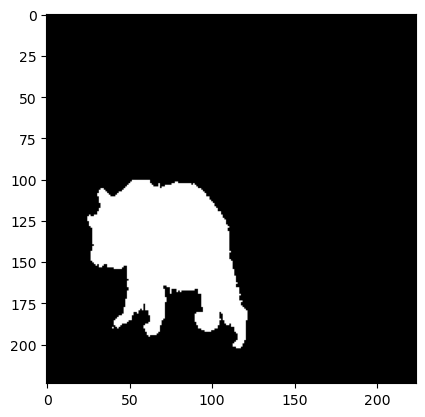

In [5]:
sgm = get_gray_image(sgm_path)
plt.imshow(sgm, cmap="gray")

In [6]:
class OneVideoDataset(Dataset):
    def __init__(self, video_name="bear"):
        with open("./uniform_samples_80.json", "r") as f:
            total_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        self.raw_data = total_data[video_name]
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self.data = []
        for i in range(len(self.raw_data) - 1):
            self.data.append(
                (
                    self.raw_data[0],
                    self.raw_data[i],
                    self.raw_data[i + 1],
                    i,
                    i + 1,
                )
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fir_frame, pre_frame, cur_frame, pre_idx, cur_idx = self.data[idx]
        fir_img = Image.open(fir_frame[0]).convert("RGB")
        pre_img = Image.open(pre_frame[0]).convert("RGB")
        cur_img = Image.open(cur_frame[0]).convert("RGB")
        fir_img = self.transform(fir_img)
        pre_img = self.transform(pre_img)
        cur_img = self.transform(cur_img)

        fir_bou = np.array(fir_frame[2]).astype(np.int32)
        pre_bou = np.array(pre_frame[2]).astype(np.int32)
        cur_bou = np.array(cur_frame[2]).astype(np.int32)

        return (
            fir_img,
            fir_bou,
            pre_img,
            cur_img,
            pre_bou,
            cur_bou,
            pre_idx,
            cur_idx,
        )

In [16]:
test_set = DAVIS_test()
dataset = OneVideoDataset()
batch_size = 1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
(
    first_frame,
    first_boundary,
    pre_frame,
    curr_frame,
    pre_boundary,
    curr_boundary,
    pre_idx,
    curr_idx,
) = next(iter(data_loader))
pre_idx, curr_idx

(tensor([40]), tensor([41]))

Text(0.5, 1.0, 'First Frame in test set')

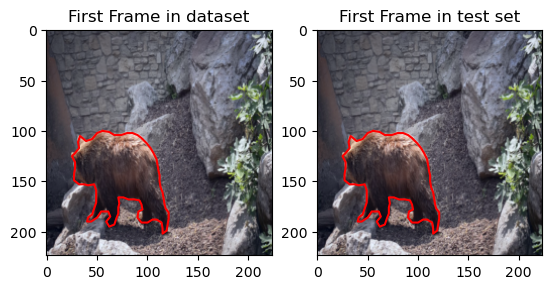

In [13]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(first_frame[index].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in dataset")
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(test_set[0][0].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in test set")

Text(0.5, 1.0, 'Curr Frame')

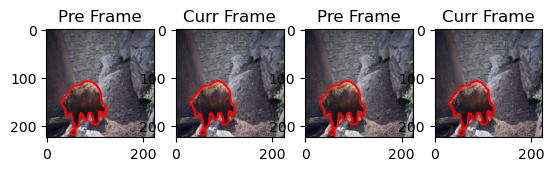

In [17]:
index = 0
plt.subplot(1, 4, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')
plt.subplot(1, 4, 3)
plt.imshow(normalize_image(test_set[pre_idx][0].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 4)
plt.imshow(normalize_image(test_set[curr_idx][0].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')